In [44]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

In [46]:
from flamingchoripan.files import search_for_filedirs
from lchandler import C_

root_folder = '../../astro-lightcurves-handler/save'
root_folder = '../../sne-lightcurves-synthetic/save'
filedirs = search_for_filedirs(root_folder, fext=C_.EXT_SPLIT_LIGHTCURVE)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../../sne-lightcurves-synthetic/save)
(0) - ../../sne-lightcurves-synthetic/save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_kfid-0_method-curvefit.splcds - 140.745[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────
filedirs after searching with filters: (../../sne-lightcurves-synthetic/save)
(0) - ../../sne-lightcurves-synthetic/save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_kfid-0_method-curvefit.splcds - 140.745[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────


In [47]:
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir
from lchandler import C_

def load_lcdataset(filename):
    assert filename.split('.')[-1]==C_.EXT_SPLIT_LIGHTCURVE
    return load_pickle(filename)

filedir = '../../astro-lightcurves-handler/save/alerceZTFv5.1/survey-alerceZTFv5.1_bands-gr_mode-onlySNe_kfid-0.splcds'
filedir = '../../astro-lightcurves-handler/save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_kfid-0.splcds'
filedir = '../../sne-lightcurves-synthetic/save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_kfid-0_method-curvefit.splcds'

filedic = get_dict_from_filedir(filedir)
root_folder = filedic['*rootdir*']
cfilename = filedic['*cfilename*']
lcdataset = load_lcdataset(filedir)
print(lcdataset['raw'].keys())
print(lcdataset['raw'].get_random_lcobj(False).keys())
print(lcdataset)

> loading: ../../sne-lightcurves-synthetic/save/alerceZTFv7.1/survey-alerceZTFv7.1_bands-gr_mode-onlySNe_kfid-0_method-curvefit.splcds
dict_keys(['data', 'survey', 'description', 'band_names', 'class_names', 'obs_is_flux'])
dict_keys(['days', 'obs', 'obse', 'y', 'synthetic'])
LCDataset:
[raw - samples 2,047]
(*) obs_samples: 65,174 - min_len: 6 - max_dur: 538.8[days] - p50_dur: 52.9[days]
(g) obs_samples: 28,351 - min_len: 0 - max_dur: 538.8[days] - p50_dur: 38.9[days] - p50_cadence: 3.0[days]
(r) obs_samples: 36,823 - min_len: 0 - max_dur: 538.8[days] - p50_dur: 50.9[days] - p50_cadence: 3.0[days]
   |▏       | SLSN - 33/2,047 (1.61%)
   |█████▉  | SNIa - 1,534/2,047 (74.94%)
   |▍       | SNIbc - 103/2,047 (5.03%)
   |█▍      | allSNII - 377/2,047 (18.42%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[raw_train - samples 1,636]
(*) obs_samples: 51,337 - min_len: 6 - max_dur: 443.9[days] - p50_dur: 52.9[days]
(g) obs_samples: 22,

In [48]:
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

train_lcset_name = 'train'
train_lcset_name = 'train_curvefit'
train_lcset = lcdataset[train_lcset_name]
brf_kwargs = {
    'max_depth':20,
    #'n_classes':len(train_lcset.class_names),
    #'n_informative':4,
    #'weights':train_lcset.get_class_weights(),
    #'random_state':0,
}
n = 10
balanced_rfs = []
for _ in range(n):
    brf = BalancedRandomForestClassifier(**brf_kwargs)
    #brf = RandomForestClassifier(**brf_kwargs)
    root_folder = f'../save/{train_lcset.survey}'
    x_df = pd.read_parquet(f'{root_folder}/{train_lcset_name}.x.parquet')
    y_df = pd.read_parquet(f'{root_folder}/{train_lcset_name}.y.parquet')
    features = list(x_df.columns)
    brf.fit(x_df.values, y_df.values[...,0])
    balanced_rfs.append(brf)

FileNotFoundError: ../save/alerceZTFv7.1/train_curvefit.x.parquet

In [39]:
from flamingchoripan.datascience.statistics import TopRank

rank = TopRank('features')
for k in range(len(brf.feature_importances_)):
    rank.add(features[k], brf.feature_importances_[k])
rank.calcule_rank()
print(rank)

features[top10]:
(1) - LinearTrend_g: 0.03349079623471171
(2) - SPM_t0_g: 0.028457245335778952
(3) - SPM_tau_rise_r: 0.028373514483215265
(4) - LinearTrend_r: 0.02570562928008155
(5) - SPM_gamma_r: 0.024655418859909645
(6) - SPM_gamma_g: 0.02406475051554973
(7) - SPM_tau_rise_g: 0.020892142776176757
(8) - SPM_t0_r: 0.020318753748588558
(9) - IAR_phi_r: 0.019237460644706193
(10) - CAR_sigma_r: 0.018571432917596484


In [40]:
from flamingchoripan.datascience.metrics import get_all_metrics_c

val_lcset_name = 'val'
x_df = pd.read_parquet(f'{root_folder}/{val_lcset_name}.x.parquet')
y_df = pd.read_parquet(f'{root_folder}/{val_lcset_name}.y.parquet')
y_target = y_df.values[...,0]
cms = []
for brf in balanced_rfs:
    y_pred = brf.predict(x_df.values)
    #print(y_pred.shape,y_target.shape)
    class_names = train_lcset.class_names
    r, rr, cm = get_all_metrics_c(y_pred, y_target, class_names, pred_is_onehot=False)
    cms.append(cm[None])
    #print()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(<Figure size 480x400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f00e722ac10>)

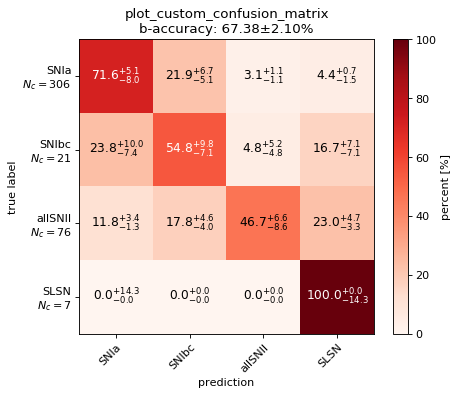

In [41]:
%load_ext autoreload
%autoreload 2
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix

new_order_classes = ['SNIa', 'SNIbc', 'allSNII', 'SLSN']
plot_custom_confusion_matrix(np.concatenate(cms, axis=0), class_names, new_order_classes, figsize=(6,5))